In [14]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import time
import copy
import os
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets
import matplotlib.pyplot as plt
import cv2
from datetime import datetime
from torch.optim import lr_scheduler
import albumentations
from PIL import Image
from PIL import ImageFile

In [2]:
class ClassificationDataset:
    def __init__(self, image_paths, targets, resize=None):
        self.image_paths = image_paths
        self.targets = targets
        self.resize = resize
        
        # ImageNet mean and std
        mean = (0.485, 0.456, 0.406)
        std = (0.229, 0.224, 0.225)
        self.aug = albumentations.Compose(
            [
                albumentations.Normalize(
                    mean, std, max_pixel_value=255.0, always_apply=True)
            ]
        )

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, item):
        image = Image.open(self.image_paths[item]).convert("RGB")
        targets = self.targets[item]
        accelerate_target = targets[2]
        steering_target = targets[0]
        if self.resize is not None:
            image = image.resize(
                resize, resample=Image.BILINEAR
            )

        image = np.array(image)
        augmented = self.aug(image=image)
        image = augmented["image"]
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        
        return {
            "images": torch.tensor(image, dtype=torch.float),
            "accelerate_targets": torch.tensor(accelerate_target, dtype=torch.float),
            "steering_targets": torch.tensor(steering_target, dtype=torch.float)
        }

In [10]:
import glob
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
batch_size = 128
resize = (66,200)
DATA_DIR = "/home/gabriel/Área de Trabalho/mk8_dataset-roi"
image_files = glob.glob(os.path.join(DATA_DIR, "*.png"))
targets_orig = [eval(x.split("/")[-1][:-4].split("-hash_")[0]) for x in image_files] #list of lists containing the relevant list in the filename for each image

train_images,test_images,train_targets,test_targets = model_selection.train_test_split(
    image_files, targets_orig, test_size=0.1, random_state=42)

train_dataset = ClassificationDataset(
    image_paths=train_images,
    targets=train_targets,
    resize=resize
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=1,
    shuffle=True,
)

test_dataset = ClassificationDataset(
    image_paths=test_images,
    targets=test_targets,
    resize=resize,
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    num_workers=1,
    shuffle=False,
)

dataloaders = {
    "train": train_loader,
    "val": test_loader 
}

In [4]:
train_dataset.__getitem__(1)

{'images': tensor([[[-0.5082, -0.0801,  0.4679,  ..., -0.0972, -0.2856, -0.1657],
          [-0.4568, -0.6281, -0.2513,  ..., -0.0801, -0.2856, -0.1657],
          [-0.4226, -0.6965, -0.5082,  ..., -0.0801, -0.3027, -0.1828],
          ...,
          [-0.1486, -0.1657, -0.1657,  ..., -0.0801, -0.1143, -0.2513],
          [-0.1486, -0.1657, -0.1828,  ..., -0.1486, -0.1143, -0.2342],
          [-0.1657, -0.1314, -0.1657,  ..., -0.1486, -0.0972, -0.1999]],
 
         [[ 0.3277,  1.7983,  2.2710,  ..., -0.3375, -0.5126, -0.7927],
          [ 0.3277,  1.2906,  1.6758,  ..., -0.3375, -0.5126, -0.7752],
          [ 0.3978,  1.1506,  1.3957,  ..., -0.3200, -0.5126, -0.7752],
          ...,
          [-0.1450, -0.1625, -0.1450,  ..., -0.0399, -0.0749, -0.2150],
          [-0.1275, -0.1450, -0.1625,  ..., -0.0924, -0.0574, -0.2150],
          [-0.1450, -0.1275, -0.1450,  ..., -0.1099, -0.0224, -0.1800]],
 
         [[ 0.1476,  1.6988,  2.4831,  ..., -1.1596, -1.2293, -1.3339],
          [ 0.0605

# Autonomous Steering model and training

In [5]:
class SteeringModel(nn.Module):
    #reference: https://arxiv.org/abs/1604.07316
    def __init__(self):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=24, kernel_size=(5,5),stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=24, out_channels=36, kernel_size=(5,5),stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=36, out_channels=48, kernel_size=(5,5),stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=48, out_channels=64, kernel_size=(3,3),stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3),stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1152,100),
            nn.Linear(100,50),
            nn.Linear(50,10),
            nn.Linear(10,1)
        )
    def forward(self,inputs):
        x = self.backbone(inputs)
        return x

In [6]:
lr=0.001
model = SteeringModel()
device = torch.device('cuda')
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer,step_size=7, gamma=0.1)
criterion = nn.MSELoss()

In [11]:
from tqdm.notebook import tqdm
num_epoches = 40
train_losses = []
val_losses = []
lowest_loss = 500.0
best_model_wts = copy.deepcopy(model.state_dict())
since = time.time()
for epoch in range(num_epoches):
    print('Epoch {}/{}'.format(epoch, num_epoches - 1))
    print('-' * 10)
    running_loss = 0.0
    for phase in ["train", "val"]:
        if phase == "train":
            model.train()
        else:
            model.eval()
            
        for inputs in tqdm(dataloaders[phase]):
            # unpack data in train_loader
            batch_images = inputs["images"]
            #acc_targets = inputs["accelerate_targets"]
            steer_targets = inputs["steering_targets"]

            # adds dimensions to convert into single row tensor
            #acc_targets =  torch.unsqueeze(acc_targets, 1)
            steer_targets =  torch.unsqueeze(steer_targets, 1)

            # insert data in cpu or gpu
            batch_images.to(device)
            #acc_targets.to(device)
            steer_targets.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == "train"):
                #print(phase == 'train')
                steer_out = model(batch_images)
                #acc_loss = accelerate_loss(acc_out,acc_targets)
                #steer_loss = steering_loss(steer_out,steer_targets)
                loss = criterion(steer_out,steer_targets)

            if phase== "train":
                loss.backward()
                optimizer.step()

            running_loss += loss.item() # batch_size
            
        epoch_loss = running_loss / len(dataloaders[phase]) * batch_size
        
        if phase == "train":
            train_losses.append(epoch_loss)
            scheduler.step()
        else:
            if epoch_loss < lowest_loss:
                lowest_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                PATH = f'./mk8-model-checkpoints/mk8-model-roi-checkpoint-epoche-{epoch}.pth'
                torch.save(model.state_dict(), PATH)
            val_losses.append(epoch_loss)

        print(f"{datetime.now().time().replace(microsecond=0)} - Loss for {phase}: {epoch_loss}")
        
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
PATH = './mk8-steering-model.pth'
model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), PATH)

Epoch 0/39
----------



23:49:30 - Loss for train: 15.890300468162254



23:50:08 - Loss for val: 153.1043140888214
Epoch 1/39
----------



23:54:28 - Loss for train: 8.636414651517514



23:54:46 - Loss for val: 85.05754212538402
Epoch 2/39
----------



23:58:34 - Loss for train: 6.569790731977533



23:59:12 - Loss for val: 65.20782782634099
Epoch 3/39
----------



00:03:19 - Loss for train: 5.821202132436964



00:03:41 - Loss for val: 58.49931102991104
Epoch 4/39
----------



00:07:35 - Loss for train: 5.42223733663559



00:07:52 - Loss for val: 54.84778066476186
Epoch 5/39
----------



00:11:44 - Loss for train: 4.916076134752344



00:12:06 - Loss for val: 49.17202631632487
Epoch 6/39
----------



00:15:56 - Loss for train: 4.333953166449511



00:16:30 - Loss for val: 44.2759752869606
Epoch 7/39
----------



00:20:11 - Loss for train: 3.3740872597252882



00:20:29 - Loss for val: 34.83506068587303
Epoch 8/39
----------



00:24:02 - Loss for train: 3.1617964064633406



00:24:20 - Loss for val: 32.81989105542501
Epoch 9/39
----------



00:27:47 - Loss for train: 3.056817394715768



00:28:06 - Loss for val: 31.874180734157562
Epoch 10/39
----------



00:31:23 - Loss for train: 2.9567375448015003



00:31:41 - Loss for val: 30.94582200050354
Epoch 11/39
----------



00:34:49 - Loss for train: 2.8733191622628107



00:35:14 - Loss for val: 30.183833916982014
Epoch 12/39
----------



00:38:20 - Loss for train: 2.8030779284459575



00:38:54 - Loss for val: 29.51009675860405
Epoch 13/39
----------



00:42:02 - Loss for train: 2.7172342847894737



00:42:20 - Loss for val: 28.711186289787292
Epoch 14/39
----------



00:45:22 - Loss for train: 2.572576649762966



00:45:40 - Loss for val: 27.352250675360363
Epoch 15/39
----------



00:48:38 - Loss for train: 2.549253860005626



00:48:56 - Loss for val: 27.13249795635541
Epoch 16/39
----------



00:51:51 - Loss for train: 2.5482214617508427



00:52:08 - Loss for val: 27.10583450893561
Epoch 17/39
----------



00:55:03 - Loss for train: 2.5451880870042025



00:55:21 - Loss for val: 27.099789718786877
Epoch 18/39
----------



00:58:15 - Loss for train: 2.5167197618219586



00:58:32 - Loss for val: 26.82988112171491
Epoch 19/39
----------



01:01:23 - Loss for train: 2.49510610765881



01:01:41 - Loss for val: 26.620637496312458
Epoch 20/39
----------



01:04:32 - Loss for train: 2.4869653152094946



01:04:50 - Loss for val: 26.5494587123394
Epoch 21/39
----------



01:07:39 - Loss for train: 2.4693301916122437



01:07:57 - Loss for val: 26.387551605701447
Epoch 22/39
----------



01:10:46 - Loss for train: 2.472844543280425



01:11:04 - Loss for val: 26.418367226918537
Epoch 23/39
----------



01:13:51 - Loss for train: 2.4653663944315025



01:14:09 - Loss for val: 26.3505795498689
Epoch 24/39
----------



01:16:53 - Loss for train: 2.464434579566673



01:17:11 - Loss for val: 26.342323184013367
Epoch 25/39
----------



01:19:55 - Loss for train: 2.465857038895289



01:20:13 - Loss for val: 26.354986091454823
Epoch 26/39
----------



01:22:53 - Loss for train: 2.460183377619143



01:23:14 - Loss for val: 26.30418477455775
Epoch 27/39
----------



01:25:58 - Loss for train: 2.4735870946336678



01:26:16 - Loss for val: 26.42364185055097
Epoch 28/39
----------



01:28:59 - Loss for train: 2.4629398032470986



01:29:17 - Loss for val: 26.328471501668293
Epoch 29/39
----------



01:31:58 - Loss for train: 2.4628475827199443



01:32:15 - Loss for val: 26.32754895091057
Epoch 30/39
----------



01:35:00 - Loss for train: 2.4785604421739227



01:35:17 - Loss for val: 26.469091564416885
Epoch 31/39
----------



01:37:59 - Loss for train: 2.4622966249783835



01:38:17 - Loss for val: 26.323030432065327
Epoch 32/39
----------



01:40:59 - Loss for train: 2.457501088027601



01:41:18 - Loss for val: 26.279968589544296
Epoch 33/39
----------



01:43:57 - Loss for train: 2.4683142745936357



01:44:18 - Loss for val: 26.377429256836574
Epoch 34/39
----------



01:46:56 - Loss for train: 2.458669748571184



01:47:16 - Loss for val: 26.290522436300915
Epoch 35/39
----------



01:49:53 - Loss for train: 2.4571347645035497



01:50:14 - Loss for val: 26.276710619529087
Epoch 36/39
----------



01:52:53 - Loss for train: 2.472232728092759



01:53:13 - Loss for val: 26.412591606378555
Epoch 37/39
----------



01:55:51 - Loss for train: 2.4544408277229026



01:56:10 - Loss for val: 26.252450267473858
Epoch 38/39
----------



01:58:53 - Loss for train: 2.463936518739771



01:59:11 - Loss for val: 26.337912499904633
Epoch 39/39
----------



02:01:53 - Loss for train: 2.4559090005026922



02:02:10 - Loss for val: 26.26569511493047
Training complete in 137m 37s


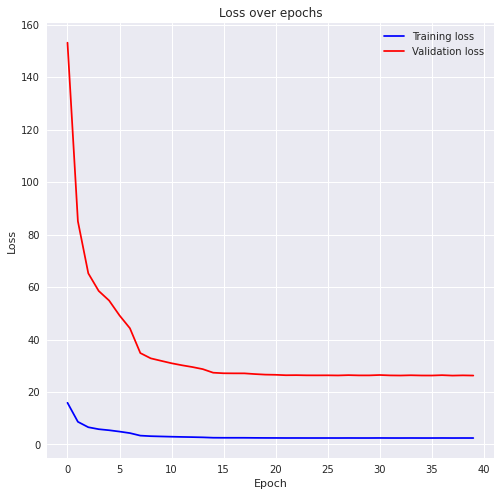

In [23]:
def plot_losses(train_losses:list, valid_losses:list):
    plt.style.use('seaborn')
    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)
    fig, ax = plt.subplots(figsize = (8, 8))
    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    plt.style.use('default')
    plt.show()
    
plot_losses(train_losses, val_losses)

(array([3791.,  516.,  285.,  214., 1618., 5962.,  229.,  306.,  412.,
        1936.]),
 array([-1.00000000e+00, -8.00003052e-01, -6.00006104e-01, -4.00009155e-01,
        -2.00012207e-01, -1.52587891e-05,  1.99981689e-01,  3.99978638e-01,
         5.99975586e-01,  7.99972534e-01,  9.99969482e-01]),
 <BarContainer object of 10 artists>)

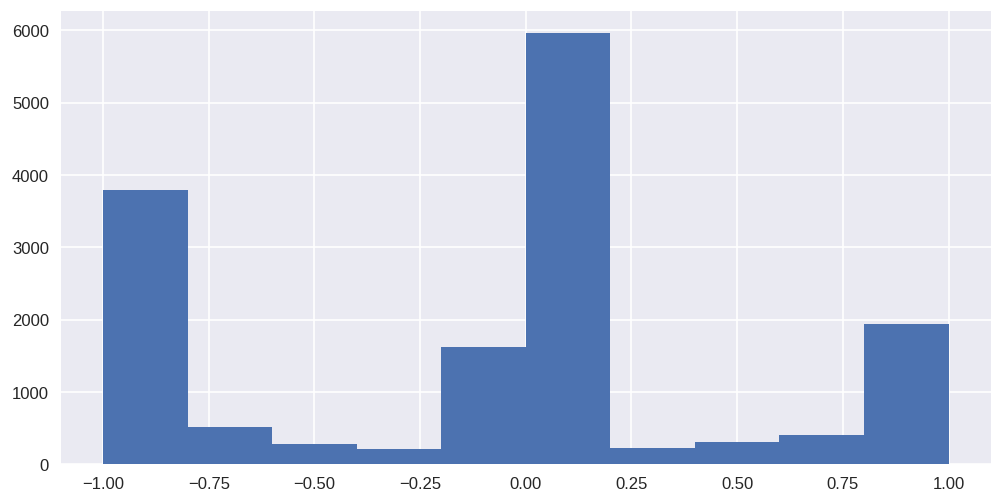

In [22]:
steering_data = [x[0] for x in targets_orig]
figure(figsize=(10, 5), dpi=120)
plt.style.use('seaborn')
plt.hist(steering_data)

In [ ]:
# Unbalanced data between left and right steering, maybe need to collect better data.